In [2]:
import pandas as pd
import os
import tifffile as tiff
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import nd2
import cc3d
import pickle

from scipy import signal
from scipy import stats
from scipy import ndimage as ndi
from scipy.spatial.distance import cdist
from scipy.optimize import curve_fit
from scipy.spatial import KDTree

from skimage.util import img_as_float, img_as_int
from skimage.feature import peak_local_max
from skimage import filters

from stardist.models import StarDist2D
from stardist.plot import render_label
from csbdeep.utils import normalize

from skimage import morphology
from skimage.filters import threshold_multiotsu, threshold_otsu, sobel
from skimage.segmentation import watershed, expand_labels, mark_boundaries, clear_border, random_walker
from skimage.filters import rank, laplace, gaussian
from skimage.measure import regionprops, regionprops_table
from skimage import measure
from skimage import restoration
from skimage.exposure import rescale_intensity
from skimage.draw import disk

import tifffile as tf

In [3]:
def getimfolder(experiment):
    import os
    basedir = ""
    data = "E:\Raphael\Data"
    for folder in os.listdir(data):
        if str(experiment) in folder:
            basedir = os.path.join(data, folder)
    return basedir

experiment = "X"
rep = 1
PID = 0
NDID = 0
stack = 0
Group1 = "FY"
Group2 = "LAMP1"
Channel1 = "DAPI"
Channel2 = "GFP"
Channel3 = "568_2"

basedir = getimfolder(experiment)
info = os.path.join(basedir, "Info.xlsx")
#idf = pd.read_excel(info)

In [4]:
def readimages(rawdir, splitdir, ID, NDID,rep,G1):
    import os
    import tifffile as tiff
    import nd2
    data = {"ID":[], "PID":[], "Channel": [], "ChID": [], "xlen": [], "ylen":[], "Group1":[], "NDID":[],"Rep":[], "path":[]}
    for ndimg in os.listdir(rawdir):
        PID = 0
        iml = os.path.join(rawdir, ndimg)
        with tf.TiffFile(iml) as ndfile:
            imgs = ndfile.series[0]

            Channels = ["aSyn_GFP", "DAPI", "ConcanavalinA", "aSyn_AB"]
            for i in range(imgs.shape[0]):
                #img = ndfile.asarray(PID)
                #img = img[:,:,i,:,:]
                #tiff.imwrite(os.path.join(splitdir,str(ID))+".tif", img)
                xlen, ylen = 0.11229814055334, 0.11229814055334
                data["ID"].append(str(ID))
                data["PID"].append(str(PID))
                data["NDID"].append(NDID)
                data["Channel"].append(Channels[i])
                data["ChID"].append(i)
                data["xlen"].append(xlen)
                data["ylen"].append(ylen)
                data["path"].append(iml)
                data["Group1"].append(G1)
                data["Rep"].append(rep)

                ID = ID+1
            NDID+=1
            PID = PID+1
    return data

def splitimages(experiment, rep):
    import os
    import pandas as pd
    basedir = getimfolder(experiment)
    rawdir = os.path.join(basedir,str(rep))
    splitdir = os.path.join(basedir,"Images")
    info = os.path.join(basedir, "Info.xlsx")
    for G1 in ["X", "TP", "FY"]:
        if os.path.exists(info) == True:
            old_df = pd.read_excel(info)
            ID = max(old_df["ID"])
            NDID = max(old_df["NDID"])
            data = readimages(os.path.join(rawdir,G1), splitdir, ID, NDID,rep,G1)
            new_df = pd.DataFrame(data = data)
            print(len(new_df))
            df = pd.concat([old_df,new_df])
            df = df.drop(df[df["Channel"] == "DIA Confocal"].index)
        else:
            ID = 0
            data = readimages(os.path.join(rawdir,G1), splitdir, ID, 0,rep,G1)
            df = pd.DataFrame(data = data)
            print(len(df))
            df = df.drop(df[df["Channel"] == "DIA Confocal"].index)
        df.to_excel(info,index=False)
    
for repi in range(1):
    repi = repi+1
    print(repi)
    #splitimages(experiment, repi)

1


In [5]:
def getImage(df, ID, basedir):
    
    iml = df["path"][df["ID"]==ID].values[0]
    i = df["ChID"][df["ID"]==ID].values[0]
    img = tf.imread(iml)
    img = img[i,:,:]
                #img = np.array(img)
    return img

In [6]:
model = StarDist2D.from_pretrained('2D_versatile_fluo')

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


1/1 [==============================] - 0s 439ms/step


Text(0.5, 1.0, 'Segmented image')

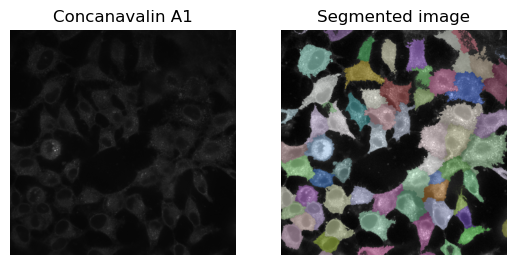

In [17]:
def rescale_before(img, pixlenimg):
    from skimage.transform import rescale
    pixlensd = 0.3488
    scaling_factor = pixlenimg/pixlensd
    image_rescaled = rescale(img, scaling_factor, anti_aliasing=True, preserve_range = True)
    return image_rescaled

def rescale_after(img, dims):
    from skimage.transform import resize
    image_resized = resize(img, dims, preserve_range=True, order=0, anti_aliasing=False).astype('uint8')
    return image_resized

def segment_cells(cells, labels):
    t = threshold_multiotsu(cells)
    minimg = np.min(cells)
    binary = cells > t[0]
    binary = ndi.binary_fill_holes(binary)
    cellL = watershed(-cells, markers = labels, mask = binary)
    return cellL

def segment_slice(NDID,basedir,idf,xlen, model):
    DAPIimg = getImage(idf, int(idf["ID"][idf["NDID"]==NDID][idf["Channel"]=="DAPI"].values[0]), basedir)
    if model == None:
        model = StarDist2D.from_pretrained('2D_versatile_fluo')
    img_rescaled_DAPI = rescale_before(DAPIimg, xlen)
    labelssd, _ = model.predict_instances(normalize(img_rescaled_DAPI))
    labels_rescaled = rescale_after(labelssd, DAPIimg.shape)
    CELLimg = getImage(idf, int(idf["ID"][idf["NDID"]==NDID][idf["Channel"]=="ConcanavalinA"].values[0]), basedir)
    cells = segment_cells(CELLimg,labels_rescaled)
    #cellL = rescale_after(cells, CELLimg.shape)
    return cells


idf = pd.read_excel(os.path.join(basedir, "Info.xlsx"))
xlen = idf["xlen"][idf["NDID"]==NDID].unique()
NDID = 1
cL = segment_slice(NDID,basedir,idf,xlen, model)
Cimg = getImage(idf, int(idf["ID"][idf["NDID"]==NDID][idf["Channel"]=="ConcanavalinA"].values[0]), basedir)

plt.subplot(1,2,1)
plt.imshow(Cimg, cmap = "gray")
plt.axis("off")
plt.title("Concanavalin A1")

plt.subplot(1,2,2)
plt.imshow(render_label(cL, img=Cimg))
plt.axis("off")
plt.title("Segmented image")

In [18]:
def measure_median(label, intensity):
    return np.median(intensity[label])

def measure_final(basedir):
    print("Hey")
    idf = pd.read_excel(os.path.join(basedir, "Info.xlsx"))
    cdf = pd.DataFrame()
    cdfs = []
    max_CID = 0
    if os.path.exists(os.path.join(basedir, "CellInfo.csv")):
        cdf = pd.read_csv(os.path.join(basedir, "CellInfo.csv"))
        idf = idf[~idf['NDID'].isin(cdf["NDID"].unique())]
        max_CID = cdf["CID"].max()+1
        cdfs = [cdf]
    for NDID in idf["NDID"].unique():
        print(NDID)
        xlen = idf["xlen"][idf["NDID"]==NDID].unique()
        cL = segment_slice(NDID,basedir,idf,xlen, model)
        GFPimg = getImage(idf, int(idf["ID"][idf["NDID"]==NDID][idf["Channel"]=="aSyn_GFP"].values[0]), basedir)
        tcdf1 = pd.DataFrame(regionprops_table(cL,intensity_image=GFPimg,properties = ('label', 'bbox', "intensity_max","intensity_min","intensity_mean"),extra_properties=(measure_median,)))
        ABimg = getImage(idf, int(idf["ID"][idf["NDID"]==NDID][idf["Channel"]=="aSyn_AB"].values[0]), basedir)
        tcdf2 = pd.DataFrame(regionprops_table(cL,intensity_image=ABimg,properties = ('label', 'bbox', "intensity_max","intensity_min","intensity_mean"),extra_properties=(measure_median,)))
        tcdf = tcdf1.merge(tcdf2, on = "label", suffixes = ("_GFP","_AB"))
        tcdf["NDID"] = NDID
        tcdf["CID"] = tcdf["label"]+max_CID
        max_CID = tcdf["CID"].max()+1
        cdfs.append(tcdf)
        cdf = pd.concat(cdfs)
        cdf.to_csv(os.path.join(basedir, "CellInfo.csv"))
    return tcdf
    
print(measure_final(basedir))

Hey
0
1/1 [==============================] - 0s 470ms/step
1
1/1 [==============================] - 0s 432ms/step
2
1/1 [==============================] - 0s 498ms/step
3
1/1 [==============================] - 0s 432ms/step
4
1/1 [==============================] - 0s 430ms/step
5
1/1 [==============================] - 0s 454ms/step
6
1/1 [==============================] - 0s 463ms/step
7
1/1 [==============================] - 0s 448ms/step
8
1/1 [==============================] - 0s 470ms/step
9
1/1 [==============================] - 0s 448ms/step
10
1/1 [==============================] - 0s 439ms/step
11
1/1 [==============================] - 0s 439ms/step
12
1/1 [==============================] - 0s 448ms/step
13
1/1 [==============================] - 0s 439ms/step
14
1/1 [==============================] - 0s 463ms/step
15
1/1 [==============================] - 0s 463ms/step
16
1/1 [==============================] - 0s 432ms/step
17
1/1 [==============================] - 0s 439ms/ste

In [23]:
cdf = pd.read_csv(os.path.join(basedir, "CellInfo.csv"))
cdf.head()
print(cdf.shape)

(28578, 20)
